In [73]:
import pandas as pd
import numpy as np
import geopandas as gp
import seaborn as sn
import datetime as dt
import pylab as pl
import urllib.request
from urllib.request import urlretrieve
import zipfile
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# SECTION 1. 311 DATA MUNGING 

In [2]:
# Get the data form the open data website
# Just run if you do not have already one of the clean datasets, it takes a while to get the data
df = pd.read_csv("https://data.cityofnewyork.us/api/views/erm2-nwe9/rows.csv?accessType=DOWNLOAD")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,17,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Visualize the first 5 observations of the data
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,36412235,06/09/2017 08:01:53 AM,06/29/2017 01:30:18 PM,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,WALL,RESIDENTIAL BUILDING,11204,6801 BAY PARKWAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.611923,-73.983414,"(40.611923387615, -73.98341420024296)"
1,36412238,06/10/2017 08:31:35 AM,06/10/2017 01:22:05 PM,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11218,633 EAST 3 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.636672,-73.976119,"(40.63667188103406, -73.9761191202944)"
2,36412246,06/10/2017 03:00:29 PM,06/10/2017 03:24:32 PM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,10025,WEST 95 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.794163,-73.972726,"(40.79416271434158, -73.97272555078482)"
3,36412247,06/10/2017 09:58:21 AM,06/10/2017 03:17:27 PM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,10039,2987 8 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.830730,-73.936134,"(40.830729904331186, -73.93613432501654)"
4,36412248,06/10/2017 06:51:55 PM,06/10/2017 10:14:41 PM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,11369,106-14 DITMARS BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.765496,-73.863849,"(40.765496327953315, -73.86384884813525)"


In [4]:
# Look at the shape of the data
df.shape

(9327811, 53)

We can see how big the entire dataset is! We need some cleaning. First just get the years we are interested in (2013, 2014 and 2015) then get rid of some columns we really do not need, then just keep the Noise complaints that are the main focus of our work.

In [5]:
# Visualize all the columns the data has
df.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry 

In [6]:
# Visualize the complaint types so that we get only noise
df["Complaint Type"].unique()

array(['PAINT/PLASTER', 'Blocked Driveway', 'PLUMBING', 'Noise - Park',
       'Illegal Parking', 'UNSANITARY CONDITION', 'Derelict Vehicles',
       'Sanitation Condition', 'Missed Collection (All Materials)',
       'Homeless Person Assistance', 'WATER LEAK', 'HEAT/HOT WATER',
       'Noise - Residential', 'Noise', 'New Tree Request', 'DOOR/WINDOW',
       'Sewer', 'Illegal Tree Damage', 'Noise - Commercial',
       'Water System', 'Water Conservation', 'Taxi Complaint',
       'Animal Abuse', 'Street Condition', 'Damaged Tree',
       'Non-Emergency Police Matter', 'Street Sign - Damaged', 'Smoking',
       'Overgrown Tree/Branches', 'ELECTRIC', 'Noise - Vehicle',
       'Elevator', 'FLOORING/STAIRS',
       'Request Large Bulky Item Collection', 'Dead/Dying Tree',
       'Plumbing', 'APPLIANCE', 'Violation of Park Rules',
       'Maintenance or Facility', 'ELEVATOR', 'GENERAL', 'SAFETY',
       'Street Sign - Missing', 'General Construction/Plumbing',
       'Dirty Conditions', 'No

In [7]:
# Check the variable type of Created Date.
type(df['Created Date'].iloc[1])

str

In [28]:
noise = df[df["Complaint Type"] == "Noise"]

In [29]:
# Convert to date time
noise['Created Date'] = pd.to_datetime(noise['Created Date'])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [30]:
# Set the maximum and minimum dates we want in our dataset
start_date = '01/01/2013'
end_date = '12/31/2015'

noise =  noise[noise["Created Date"]>start_date]
noise =  noise[noise["Created Date"]<end_date]

In [31]:
# See how many observations we dropped
print (df.shape)
print (noise.shape)

(9327811, 53)
(146301, 53)


In [32]:
noise.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry 

In [34]:
# We keep only the columns we are interested in
noise = noise[["Unique Key", "Created Date", "Agency", "Agency Name", 
         "Complaint Type", "Descriptor", "Incident Zip", "Community Board", "Borough", "School Name", 
         "School Number", "School Code", "School or Citywide Complaint", "Latitude", "Longitude", "Location"]]

In [35]:
noise.shape

(146301, 16)

In [46]:
# We are only interested in observations we can geo localize so we check if the column has nan values.
noise1 = noise[noise['Location']=="NaN"]

In [47]:
noise.shape

(146301, 16)

In [48]:
noise1.shape

# It doesn't have any NaN values. How great!

(0, 16)

In [50]:
# We save the data as a csv file in case we want to reload it without spending so much time
noise.to_csv('311data.csv')

In [51]:
noise.head()

,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Incident Zip,Community Board,Borough,School Name,School Number,School Code,School or Citywide Complaint,Latitude,Longitude,Location
203401,29121436,2014-10-22 01:16:00,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),10003,03 MANHATTAN,MANHATTAN,Unspecified,Unspecified,Unspecified,NaN,40.732354,-73.987855,"(40.73235370534885, -73.98785478843209)"
304668,31128978,2015-07-21 22:31:00,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),11218,14 BROOKLYN,BROOKLYN,Unspecified,Unspecified,Unspecified,NaN,40.645393,-73.969781,"(40.64539331933518, -73.96978104471124)"
304964,31310515,2015-08-14 00:13:00,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),11692,14 QUEENS,QUEENS,Unspecified,Unspecified,Unspecified,NaN,40.591418,-73.791317,"(40.591418105600994, -73.7913169371139)"
305039,31350851,2015-08-19 07:09:00,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),11368,03 QUEENS,QUEENS,Unspecified,Unspecified,Unspecified,NaN,40.754693,-73.864145,"(40.754693353809444, -73.86414524439152)"
305223,31476576,2015-09-06 16:19:00,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),11211,01 BROOKLYN,BROOKLYN,Unspecified,Unspecified,Unspecified,NaN,40.718651,-73.953089,"(40.718651195412065, -73.95308857167933)"


In [52]:
noise.shape

(146301, 16)

In [53]:
# We group the noise complaints in differen time subsets in order to visualize them
grph = noise.groupby(noise["Created Date"].dt.hour).count()
grpd = noise.groupby(noise["Created Date"].dt.weekday).count()
grpw = noise.groupby(noise["Created Date"].dt.week).count()
grpy = noise.groupby(noise["Created Date"].dt.year).count()

In [55]:
grpd.head(1)

,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Incident Zip,Community Board,Borough,School Name,School Number,School Code,School or Citywide Complaint,Latitude,Longitude,Location
Created Date,,,,,,,,,,,,,,,,
0,20128,20128,20128,20128,20128,20128,20041,20128,20128,20128,20128,20128,0,19986,19986,19986


Text(0.5,1,'Complaints in NYC')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


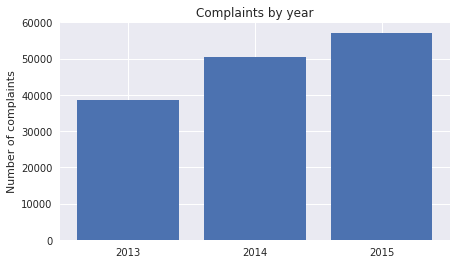

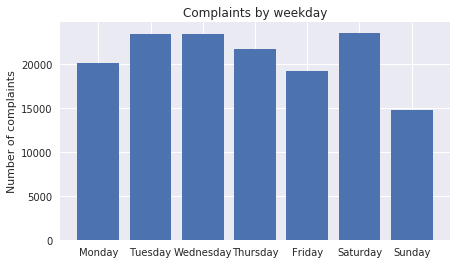

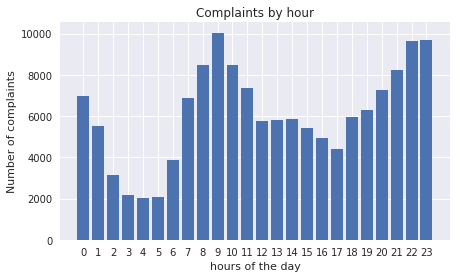

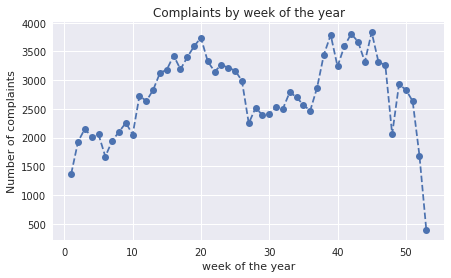

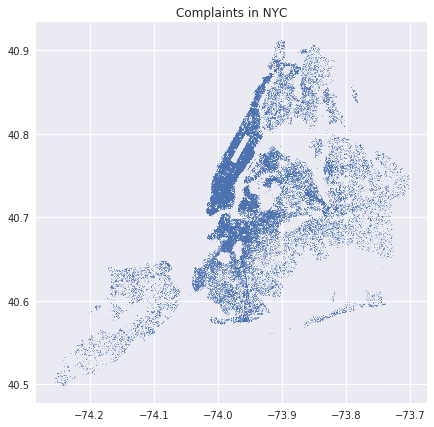

In [56]:
fig = plt.figure(figsize=(7,4))

wd = np.arange(3)
ax1 =plt.bar(wd, grpy["Unique Key"])
plt.xticks(wd, ('2013', '2014', '2015'))
pl.title("Complaints by year")
pl.ylabel("Number of complaints")

fig = plt.figure(figsize=(7,4))

wd = np.arange(7)
ax1 =plt.bar(wd, grpd["Unique Key"])
plt.xticks(wd, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', "Friday", "Saturday", "Sunday"))
pl.title("Complaints by weekday")
pl.ylabel("Number of complaints")

fig = plt.figure(figsize=(7,4))

x = np.arange(24)
ax2 = plt.bar(x, grph["Unique Key"])
plt.xticks(x, ('0', '1', '2', '3', "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14",
              "15", "16", "17", "18", "19", "20", "21", "22", "23"))
pl.title("Complaints by hour")
pl.ylabel("Number of complaints")
pl.xlabel("hours of the day")

fig = plt.figure(figsize=(7,4))
ax3 = plt.figure(figsize=(7,4))
pl.plot(grpw["Unique Key"], "--o")
pl.title("Complaints by week of the year")
pl.ylabel("Number of complaints")
pl.xlabel("week of the year")

pl.figure(figsize=(7,7))
ax4 = pl.scatter(noise.Longitude, noise.Latitude, s = 0.1)
pl.title("Complaints in NYC")

In [58]:
# We drop Saturdays and Sundays because kids do not go to school those days
noise =  noise[noise["Created Date"].dt.weekday!=6]
noise =  noise[noise["Created Date"].dt.weekday!=7]

In [60]:
print ("This is our final 311 database complaint database shape:", noise.shape)

This is our final 311 database complaint database shape: (131532, 16)


In [61]:
# Because our school results are by year then we also want our noise complaints by year
noise2013 = noise[noise["Created Date"].dt.year == 2013]
noise2014 = noise[noise["Created Date"].dt.year == 2014]
noise2015 = noise[noise["Created Date"].dt.year == 2015]

In [62]:
# We create three different datasets of noise complaints (1 by year in order to groupby census tract)
noise2013.to_csv("noise2013.csv")
noise2014.to_csv("noise2014.csv")
noise2015.to_csv("noise2015.csv")

### NOTE: in order to count the number of complaints by Census Tract we used "Carto" using the analysis of counting points inside geometries. The geometries were the census tracts provided by new york city open data. It will we used in the following data processing.  

In [64]:
# We read the resulting datasets that contain the number of complaints by Census Tract
noise_13 = pd.read_csv("noisebyct2013.csv")
noise_14 = pd.read_csv("noisebyct2014.csv")
noise_15 = pd.read_csv("noisebyct2015.csv")

In [71]:
print (noise_13.shape)
print (noise_14.shape)
print (noise_15.shape)

(2028, 15)
(2054, 15)
(2070, 15)


In [67]:
# This is a way to visualize NYC that professor Federica Bianco created, it is basically a choropleth with variations.
urllib.request.urlretrieve("https://raw.githubusercontent.com/fedhere/choroplethNYC/master/choroplethNYC.py","choroplethNYC.py")
import choroplethNYC as cp

In [81]:
# Make the datasets geo data frames in order to map them
noise_13_ = gp.GeoDataFrame(noise_13)
noise_14_ = gp.GeoDataFrame(noise_14)
noise_15_ = gp.GeoDataFrame(noise_15)

In [75]:
#we unzip the census tract shapefile (it will be attached with the code in a separate file)
zip_ref = zipfile.ZipFile("2010 Census Tracts.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [76]:
# We read the file as a geodataframe
ct = gp.GeoDataFrame.from_file("geo_export_19d388ec-f34e-4b0d-b74d-a31e738347e7.shp")

In [77]:
ct.head(1)

,puma,boro_ct201,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,geometry
0,3903,5000900,000900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,9,POLYGON ((-74.07920577013245 40.64343078374567...


In [72]:
noise_13_.columns

Index(['cartodb_id', 'the_geom', 'puma', 'boro_ct201', 'ct2010', 'ntaname',
       'ntacode', 'boro_name', 'shape_leng', 'shape_area', 'cdeligibil',
       'boro_code', 'ctlabel', 'count_vals', 'count_vals_density'],
      dtype='object')

In [83]:
noise_13_["boro_ct201"] = noise_13_["boro_ct201"].astype(str)
noise_14_["boro_ct201"] = noise_14_["boro_ct201"].astype(str)
noise_15_["boro_ct201"] = noise_15_["boro_ct201"].astype(str)

ct["boro_ct201"] = ct["boro_ct201"].astype(str)


In [84]:
# In order to map the number of complaints by census tract we must merge the datasets

noise_13_ = pd.merge(ct, noise_13_, on="boro_ct201")
noise_14_ = pd.merge(ct, noise_14_, on="boro_ct201")
noise_15_ = pd.merge(ct, noise_15_, on="boro_ct201")

In [85]:
noise_13_.head()

,puma_x,boro_ct201,ct2010_x,ntaname_x,ntacode_x,boro_name_x,shape_leng_x,shape_area_x,cdeligibil_x,boro_code_x,...,ntaname_y,ntacode_y,boro_name_y,shape_leng_y,shape_area_y,cdeligibil_y,boro_code_y,ctlabel_y,count_vals,count_vals_density
0,3903,5000900,000900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,...,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,9.0,1.0,0.000004
1,3808,1009800,009800,Turtle Bay-East Midtown,MN19,Manhattan,5534.199811,1.906016e+06,I,1,...,Turtle Bay-East Midtown,MN19,Manhattan,5534.199811,1.906016e+06,I,1,98.0,237.0,0.001338
2,3808,1010000,010000,Turtle Bay-East Midtown,MN19,Manhattan,5692.168737,1.860938e+06,I,1,...,Turtle Bay-East Midtown,MN19,Manhattan,5692.168737,1.860938e+06,I,1,100.0,78.0,0.000451
3,3807,1010200,010200,Midtown-Midtown South,MN17,Manhattan,5687.802439,1.860993e+06,I,1,...,Midtown-Midtown South,MN17,Manhattan,5687.802439,1.860993e+06,I,1,102.0,53.0,0.000307
4,3807,1010400,010400,Midtown-Midtown South,MN17,Manhattan,5693.036367,1.864600e+06,I,1,...,Midtown-Midtown South,MN17,Manhattan,5693.036367,1.864600e+06,I,1,104.0,90.0,0.000520


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


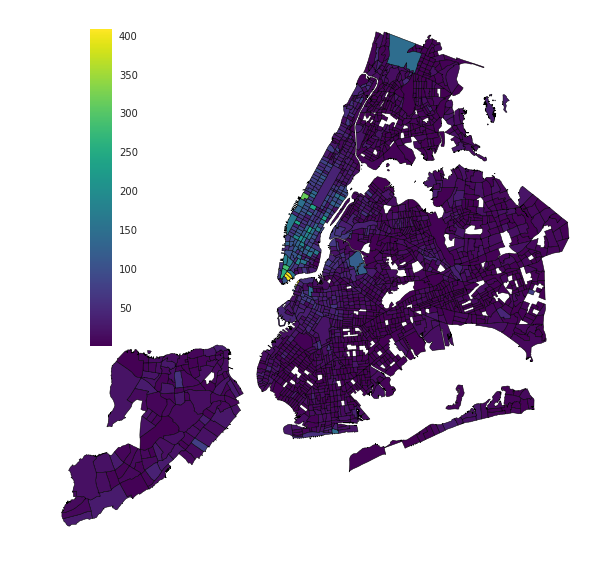

In [86]:
cp.choroplethNYC(noise_13_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


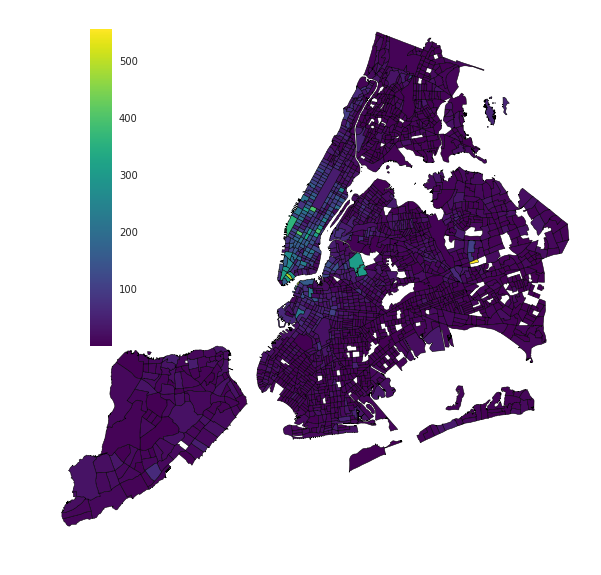

In [87]:
cp.choroplethNYC(noise_14_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


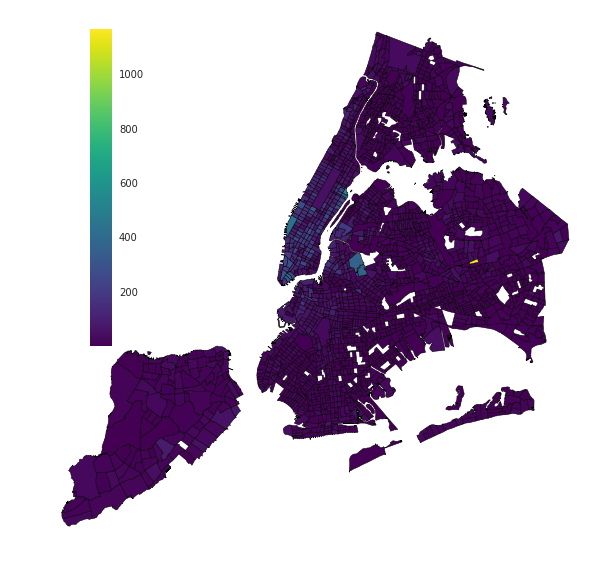

In [88]:
cp.choroplethNYC(noise_15_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

# SECTION 2. SCHOOL DATA MUNGING 

# SECTION 3. 311 LODES DATA MUNGING 

# SECTION 4.  FINAL MERGE  AND MODELS